In [1]:
import os, sys
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import grid_search
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Utility function to extract text
The Gutenberg project adds extra information to the begin and end of each ebook, we don't want these text to affect the result. Also, there's no need to include complete book content; all we need is enough text to know the style of the author. Therefore, here we partition the book into 3 parts and take only the middle part.

In [2]:
def cleanDocument(file):
    lines = file.split("\n")
    n = len(lines)
    begin, end = n//3, 2*n//3
    lines = lines[begin:end]
    lines = (line for line in lines if len(line)>0)
    return "\n".join(lines)

### Loading data
The data is kept in the directory "dataset" and categorized into subfolders with respect to each author. Thus, the label for each document will be the subfolder (in integer value) where it locates. A look-up table is generated so that we can map the integer values to subfolder name in string. Finally, do a train-test split and keep 0.2 of the data as our testing set. 

In [22]:
authors_dict = {}
def loadData(path):
    documents, authors = [], []
    subfolders = [subfolder for subfolder in os.listdir(path) if os.path.isdir(os.path.join(path, subfolder))]
    for i, subfolder in enumerate(subfolders):
        subpath = os.path.join(path, subfolder)
        authors_dict[i] = subfolder
        for f_name in os.listdir(subpath):
            if not f_name.endswith('.txt'):
                continue
            with open(os.path.join(subpath, f_name), 'r', encoding='utf-8') as f:
                cleanedText = cleanDocument(f.read())
                documents.append(cleanedText)
                authors.append(i)
    return documents, np.array(authors, dtype='int')
documents_all, authors_all = loadData('datasets')
documents, documents_test, authors, authors_test = train_test_split(documents_all, authors_all, test_size=0.2, random_state=2)

### Utility function to lead function word from txt file
The usage of function words is more dependent on the author's decision, so they are good features to decide an author's writing style. The function word list is obtained from https://semanticsimilarity.wordpress.com/function-word-lists/

In [18]:
def load_function_words(path):
    function_words = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            function_words.append(line.split()[0])
    return function_words
function_words = load_function_words('function_words.txt')
#print(authors_dict)

{0: 'BoothTarkington', 1: 'CharlesDickens', 2: 'JulesVerne', 3: 'MarkTwain', 4: 'Shakespeare'}


### The models and training
Here I use three different models: function word features, n-gram features (unigram and bigram) and TfIdf features. These features can be easily extracted with scikit-learn's vectorizers. I use grid search function to determine the best parameter settings, and I output the trained model the fitted vectorizer for later use in prediction.

In [28]:
def svmWithExtractor(extractor):
    X = extractor.fit_transform(documents)
    X_train, X_val, y_train, y_val = train_test_split(X, authors, test_size=0.2, random_state=2)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svm = SVC()
    grid = grid_search.GridSearchCV(svm, parameters)
    grid.fit(X_train, y_train)
    print('Best parameters:', grid.best_params_)
    y_true, y_pred = y_val, grid.predict(X_val)
    report = classification_report(y_true, y_pred)
    print(report)
    values = np.array(list(map(float, report.split('\n')[-2].split()[3:6])))
    return grid, extractor
print('Classification with function words:')
svmFW, FWextractor = svmWithExtractor(CountVectorizer(vocabulary=function_words))
print('Classification with unigram and bigram:')
svmNG, NGextractor = svmWithExtractor(CountVectorizer(analyzer='word', ngram_range=(1, 2)))
print('Classification with unigram TfIdf:')
svmTfIdf, TfIdfextractor = svmWithExtractor(TfidfVectorizer())

Classification with function words:
Best parameters: {'C': 1, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       0.67      1.00      0.80         2
          2       1.00      1.00      1.00         4
          3       1.00      0.67      0.80         3
          4       1.00      1.00      1.00         5

avg / total       0.96      0.93      0.93        15

Classification with unigram and bigram:
Best parameters: {'C': 1, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.67      1.00      0.80         2
          2       1.00      1.00      1.00         4
          3       0.67      0.67      0.67         3
          4       1.00      1.00      1.00         5

avg / total       0.82      0.87      0.84        15

Classification with unigram TfIdf:


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'C': 10, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00         4
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00        15



### Run prediction
Now we're ready to run prediction with the trained model and test set. We need to use the fitted vectorizer from training stage to do feature extraction. I loop through each testing document and compare the true label with predicted label. The averaged performance metric (precision, recall and f1-score) is returned so that we can plot to compare the performance of different models. 

In [31]:
def predictWithExtractor(svm, extractor):
    X = extractor.transform(documents_test)
    y_preds = svm.predict(X)
    report = classification_report(authors_test, y_preds)
    values = np.array(list(map(float, report.split('\n')[-2].split()[3:6])))
    for i, y_pred in enumerate(y_preds):
        y_true = authors_test[i]
        print('True author is %s, predict author is %s' % (authors_dict[y_true], authors_dict[y_pred]))
    return values
        
print('Prediction with function words:')
FWvals = predictWithExtractor(svmFW, FWextractor)
print('\nPrediction with unigram and bigram:')
NGvals = predictWithExtractor(svmNG, NGextractor)
print('\nPrediction with unigram TfIdf:')
TfIdfvals = predictWithExtractor(svmTfIdf, TfIdfextractor)

Prediction with function words:


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


True author is JulesVerne, predict author is JulesVerne
True author is Shakespeare, predict author is Shakespeare
True author is Shakespeare, predict author is Shakespeare
True author is Shakespeare, predict author is Shakespeare
True author is JulesVerne, predict author is JulesVerne
True author is Shakespeare, predict author is Shakespeare
True author is MarkTwain, predict author is CharlesDickens
True author is BoothTarkington, predict author is BoothTarkington
True author is Shakespeare, predict author is Shakespeare
True author is BoothTarkington, predict author is BoothTarkington
True author is BoothTarkington, predict author is BoothTarkington
True author is BoothTarkington, predict author is BoothTarkington
True author is CharlesDickens, predict author is CharlesDickens
True author is Shakespeare, predict author is Shakespeare
True author is CharlesDickens, predict author is CharlesDickens
True author is CharlesDickens, predict author is CharlesDickens
True author is BoothTarki

### Another model -- based on custom features
I found this paper online: http://cs229.stanford.edu/proj2013/StankoLuHsu-AuthorIdentification.pdf which claims to have accuracy comparable to that of standard classifiers but with a significantly shorter runtime. So I tried it. The feature I use in this model is 62 dimension:
feature[0]: # of unique words
feature[1:27]: distribution for sentence length from length 1 to length 27 or more.
feature[27:45]: distribution for word length from length 1 to length 18 or more.
feature[45:55]: distribution for pronoun per sentence from length 1 to 10 or more.
feature[55:62]: distribution for conjunction per sentence from length 1 to 7 or more.
The next two cells define the required utility functions, models and do the training. 

In [7]:
def helper(arr, n):
    ret = [0]*n
    for i in arr:
        if i >= n:
            ret[n-1] += 1
        elif i > 0:
            ret[i-1] += 1
    return ret
def sentenceLengths(tokenized_sentences):  
    t = map(len, tokenized_sentences)
    return helper(t, 26)
def wordLengths(words):
    t = map(len, words)
    return helper(t, 18)
def pronounPerSentence(tokenized_sentences):
    pronouns = set(['something', 'thou', 'everybody', 'all', 'anything', 'your', 'ours', 'her', 'myself', 'him', 
                    'everything', 'I', 'nobody', 'somebody', 'whomever', 'who', 'everyone', 'none', 'each', 'thee', 
                    'thy', 'anybody', 'nothing', 'this', 'one', 'our', 'his', 'we', 'yourself', 'they', 'another', 
                    'himself', 'me', 'several', 'hers', 'no one', 'ourselves', 'both', 'some', 'itself', 'my', 
                    'whose', 'these', 'other', 'either', 'someone', 'few', 'themselves', 'thine', 'whichever', 
                    'neither', 'as', 'he', 'she', 'theirs', 'which', 'such', 'mine', 'whom', 'that', 'yourselves', 
                    'whoever', 'what', 'those', 'others', 'whatever', 'it', 'them', 'us', 'anyone', 'their', 'most', 
                    'yours', 'any', 'many', 'herself', 'you'])
    def countPronouns(sentence):
        cnt = 0
        for word in sentence:
            if word in pronouns:
                cnt += 1
        return cnt
    pronounCnts = map(countPronouns, tokenized_sentences)
    return helper(pronounCnts, 10)
def conujnctionPerSentence(tokenized_sentences):
    conjunctions = set(['and','that','but','or','as','if','when','than','because','while','where',
                        'after','so','though','since','until','whether','before','although','nor','like',
                        'once','unless','now','except'])
    def countConjunctions(sentence):
        cnt = 0
        for word in sentence:
            if word in conjunctions:
                cnt += 1
        return cnt
    conjunctionCnts = map(countConjunctions, tokenized_sentences)
    return helper(conjunctionCnts, 7)
def customFeatureExtractor(document):
    features = []
    # number of unique words
    word_tokenizer = RegexpTokenizer(r'\w+')
    words = word_tokenizer.tokenize(document.lower())
    features.append(len(set(words)))
    # sentence lengths
    sentences = sent_tokenize(document.lower())
    tokenized_sentences = list(map(word_tokenizer.tokenize, sentences))
    sl = sentenceLengths(tokenized_sentences)
    features.extend(sl)
    # word lengths
    wl = wordLengths(words)
    features.extend(wl)
    # pronoun per sentences
    pps = pronounPerSentence(tokenized_sentences)
    features.extend(pps)
    # conjunction per sentences
    cps = conujnctionPerSentence(tokenized_sentences)
    features.extend(cps)
    return features

In [33]:
def svmCustom():
    X = np.asarray(list(map(customFeatureExtractor, documents)))
    X_train, X_val, y_train, y_val = train_test_split(X, authors, test_size=0.2, random_state=2)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svm = SVC()
    grid = grid_search.GridSearchCV(svm, parameters)
    grid.fit(X_train, y_train)
    print('Best parameters:', grid.best_params_)
    y_true, y_pred = y_val, grid.predict(X_val)
    report = classification_report(y_true, y_pred)
    print(report)
    return grid
svmCF = svmCustom()

Best parameters: {'C': 1, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.50      0.50      0.50         2
          2       1.00      1.00      1.00         4
          3       0.50      0.33      0.40         3
          4       1.00      0.80      0.89         5

avg / total       0.77      0.67      0.71        15



### Run prediction for our 4th model
Based on the training report, it looks that using custom features doesn't give as good performance as the previous 3 models. Similar results occur when running prediction, we see many mis-predicted outcomes. Moreover, the runtime is also not faster much.

In [35]:
X = np.asarray(list(map(customFeatureExtractor, documents_test)))
y_preds = svmCF.predict(X)
report = classification_report(authors_test, y_preds)
CFvals = np.array(list(map(float, report.split('\n')[-2].split()[3:6])))
for i, y_pred in enumerate(y_preds):
    y_true = authors_test[i]
    print('True author is %s, predict author is %s' % (authors_dict[y_true], authors_dict[y_pred]))

True author is JulesVerne, predict author is JulesVerne
True author is Shakespeare, predict author is Shakespeare
True author is Shakespeare, predict author is Shakespeare
True author is Shakespeare, predict author is Shakespeare
True author is JulesVerne, predict author is JulesVerne
True author is Shakespeare, predict author is Shakespeare
True author is MarkTwain, predict author is MarkTwain
True author is BoothTarkington, predict author is MarkTwain
True author is Shakespeare, predict author is Shakespeare
True author is BoothTarkington, predict author is MarkTwain
True author is BoothTarkington, predict author is MarkTwain
True author is BoothTarkington, predict author is CharlesDickens
True author is CharlesDickens, predict author is CharlesDickens
True author is Shakespeare, predict author is Shakespeare
True author is CharlesDickens, predict author is CharlesDickens
True author is CharlesDickens, predict author is MarkTwain
True author is BoothTarkington, predict author is Mark

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Performance Comparison
Now let's plot the results of 4 models. TfIdf based models performs surprisingly good. Ngrams and function word models are very close but ngrams slightly better. Custom features is the worst among four.

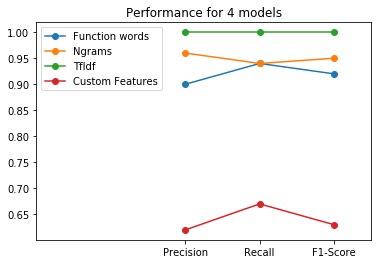

In [36]:
my_xticks = ['Precision', 'Recall', 'F1-Score']
x = np.array([2, 3, 4])
plt.xticks(x, my_xticks)
plt.xlim(0,4.5)

p1 = plt.plot(x, FWvals, '-o')
p2 = plt.plot(x, NGvals, '-o')
p3 = plt.plot(x, TfIdfvals, '-o')
p4 = plt.plot(x, CFvals, '-o')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Function words', 'Ngrams', 'TfIdf', 'Custom Features'), loc=2)
plt.title('Performance for 4 models')
plt.show()

### Additional questions:
1. How would you assess the performances of your system?  
It's a classification problem so I use precision, recall and f1-score.
2. Could your system be used to generate novel content such that it appears as being written by a given author?  
No. The models I built here only predicts the most likely author. If the task is to generate novel content given an author, then I will use deep learning and language modeling (use LSTM networks to do text generation) instead.
3. Is your system scalable w.r.t. number of documents / users? If not, how would address the scalability (in terms of algorithms, infrastructure, or both)?  
For this small project, I load everything to memory, so if we have a large number of documents and users that exceeds memory limit, it won't work. For scalability, I think more powerful hardware/infrastructure certainly helps but on the algorithm side, I would try to perform feature extraction one at a time and instead of keeping everything in memory for training, use a data generator that iteratively load extracted feature matrices from disk.